In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import pairwise_distances

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter("ignore")

# Read card definitions 
This information is stored in a CSV file
Also, apply dimensionality reduction using PCA

In [11]:
dfPlayingCardsRaw = pd.read_csv('Playing cards.csv')

outliers = dfPlayingCardsRaw.loc[dfPlayingCardsRaw['Suit']=='None'].index
dfPlayingCardsRaw.drop(labels=outliers, axis=0, inplace=True)

featureList = ['Suit', 'Color', 'Face Value']
dfPlayingCards = dfPlayingCardsRaw[featureList]

dfTrain = pd.get_dummies(dfPlayingCards)

distances = pdist(dfTrain.values, metric='euclidean')
dist_matrix = pd.DataFrame(squareform(distances), columns=list(dfTrain.index.values))

RANDOM_STATE = 1337
clusterRange = (2, dfPlayingCardsRaw.shape[0])
rescaleMode = 'None'

pca = PCA(n_components=0.95, whiten=True)
X_pca = pca.fit_transform(dfTrain)

print('Original number of features:', dfTrain.shape)
print('Reduced number of features:', X_pca.shape)

Original number of features: (52, 19)
Reduced number of features: (52, 14)


# Visualize Feature Distributions

In [ ]:
dfPCA = pd.DataFrame(X_pca)

fig, currAX = plt.subplots(figsize=(15,15))

currAX.spines['top'].set_visible(False)
currAX.spines['right'].set_visible(False)
currAX.spines['left'].set_visible(False)
currAX.spines['bottom'].set_visible(False)

sm = pd.plotting.scatter_matrix(dfPCA, alpha = 0.3, diagonal = 'kde', ax=currAX)

corr = dfPCA.corr().values#.as_matrix()
for i, j in zip(*plt.np.triu_indices_from(sm, k=1)):
    sm[i, j].annotate('{:.3f}'.format(corr[i,j]), (0.8, 0.25), xycoords='axes fraction', ha='center', va='center');

plt.show();

# Algorithms to try, with data and options

In [5]:
dictAlgorithms = \
{
    'Un-Transformed Data':\
    {
        'K-Means': dict(data=dfTrain, algorithm='KMeans', loopRange=clusterRange,
                        args=dict(random_state=RANDOM_STATE, verbose=False, max_iter=1000), 
                        plotprops=dict(linestyle='-', color='g', offsetMult=-15)),
        'Agglomerative Clustering (single)': dict(data=dfTrain, algorithm='AgglomerativeClustering', loopRange=clusterRange,
                                         args=dict(affinity='euclidean', linkage='single'), 
                                         plotprops=dict(linestyle='-', color='purple', offsetMult=5)),
        'Agglomerative Clustering (complete)': dict(data=dfTrain, algorithm='AgglomerativeClustering', loopRange=clusterRange,
                                         args=dict(affinity='euclidean', linkage='complete'), 
                                         plotprops=dict(linestyle='--', color='purple', offsetMult=15)),
        #'Agg. Clustering with linkages': dict(data=dfTrain, algorithm='AgglomerativeClustering', loopRange=clusterRange,
        #                                      args=dict(connectivity=connectivityReg, linkage='single'), 
        #                                      plotprops=dict(linestyle='-', color='red', offsetMult=10)),
        'Gaussian Mixture': dict(data=dfTrain, algorithm='GaussianMixture', loopRange=clusterRange,
                                  args=dict(random_state=RANDOM_STATE), 
                                  plotprops=dict(linestyle='-', color=(255/255, 219/255, 88/255), offsetMult=-5))
    },
    'PCA Transformed Data':\
    {
        'K-Means': dict(data=X_pca, algorithm='KMeans', loopRange=clusterRange,
                        args=dict(random_state=RANDOM_STATE, verbose=False, max_iter=1000), 
                        plotprops=dict(linestyle='-', color='g', offsetMult=-15)),
        'Agglomerative Clustering (single)': dict(data=X_pca, algorithm='AgglomerativeClustering', loopRange=clusterRange,
                                         args=dict(affinity='euclidean', linkage='single'), 
                                         plotprops=dict(linestyle='-', color='purple', offsetMult=5)),
        'Agglomerative Clustering (complete)': dict(data=X_pca, algorithm='AgglomerativeClustering', loopRange=clusterRange,
                                         args=dict(affinity='euclidean', linkage='complete'), 
                                         plotprops=dict(linestyle='--', color='purple', offsetMult=15)),
        #'Agg. Clustering with linkages': dict(data=X_pca, algorithm='AgglomerativeClustering', loopRange=clusterRange,
        #                                      args=dict(connectivity=connectivityReg, linkage='single'), 
        #                                      plotprops=dict(linestyle='-', color='red', offsetMult=10)),
        'Gaussian Mixture': dict(data=X_pca, algorithm='GaussianMixture', loopRange=clusterRange,
                                 args=dict(random_state=RANDOM_STATE), 
                                 plotprops=dict(linestyle='-', color=(255/255, 219/255, 88/255), offsetMult=-5))
    },
}

# Define function to cluster the data

In [6]:
minClusters = 2
def detectClusters(dfData, dfRaw, loopRange, algorithm='KMeans', **args):
    validAlgorithms = {
                        'KMeans'                 : {'function':KMeans,                  'hyperparameter':'n_clusters',   'validargs':set(['n_clusters', 'random_state', 'verbose', 'max_iter'])},
                        'AgglomerativeClustering': {'function':AgglomerativeClustering, 'hyperparameter':'n_clusters',   'validargs':set(['n_clusters', 'affinity', 'linkage'])},
                        'GaussianMixture'        : {'function':GaussianMixture,         'hyperparameter':'n_components', 'validargs':set(['n_components', 'random_state'])},
                        'DBSCAN'                 : {'function':DBSCAN,                  'hyperparameter':'eps',          'validargs':set(['eps', 'metric'])}
                      }
    
    if algorithm not in validAlgorithms.keys():
        raise ValueError('{} is not a recognized clustering algorithm'.format(algorithm))
        return None
    
    clusteringFunction = validAlgorithms[algorithm]['function']
    hyperParm = validAlgorithms[algorithm]['hyperparameter']
    
    if dfRaw is not None:
        dfRawClustered = dfRaw.copy() # Don't overwrite the original dataset
    else:
        dfRawClustered = None
    
    
    
    dfClusterResults = pd.DataFrame(columns=['Silhouette Score', 'Clusters', 'Silhouette Samples', 'model'])
    
    loopVals = np.arange(*loopRange)
    for i, k in enumerate(loopVals):
        args[hyperParm] = k
        clustering_model = clusteringFunction(**args)
        
        clusters = clustering_model.fit_predict(dfData)
        
        if np.unique(clusters).shape[0]>=2 :
            silhouetteScore = silhouette_score(dfData, clusters)
            silhouetteSamples = silhouette_samples(dfData, clusters)
        else:
            silhouetteScore = 0
            silhouetteSamples = [0]*dfData.shape[0]
        

        dfClusterResults.loc[k] =  [silhouetteScore, clusters, silhouetteSamples, clustering_model]
        
        if dfRawClustered is not None:
            dfRawClustered = dfRawClustered.join(pd.Series(clusters, index=dfRawClustered.index, name='cluster_id_{:02d}'.format(k)))
        del clusters
        #print('{} {} {}'.format(algorithm, k, silhouetteScore))

    return dfClusterResults, dfRawClustered

# Define function to plot clustering results

In [7]:
def PlotClusteringResults(dataDict, title, minClusters=2):
    plots = []
    fig, currAX = plt.subplots(figsize=(15,10))

    currAX.spines['top'].set_visible(False)
    currAX.spines['right'].set_visible(False)
    currAX.spines['left'].set_visible(False)
    currAX.spines['bottom'].set_visible(True)

    currAX.spines['bottom'].set_position(('data',0))
    currAX.spines['left'].set_position(('data',0))

    currAX.set_xlabel("# Clusters", fontdict={'family':'serif', 'fontsize': 14, 'fontweight': 'normal'} )
    plt.ylabel('Silhouette score', fontdict={'family':'serif', 'fontsize': 14, 'fontweight': 'normal'})
    
    currAX.set_ylim(0, 0.75, 0.1)

    
    plt.title(title,
              fontdict={'family':'serif', 'color':'darkred', 'weight': 'bold', 'size': 18, 'verticalalignment':'top'},
              y=1.25
             )

    xBottom, xTop = plt.xlim(); xOffset = (xTop - xBottom)/150
    yBottom, yTop = plt.ylim(); yOffset = (yTop - yBottom)/150
    
    for alg in dataDict.keys():
        dictDefn = dataDict[alg]
        dfData = dictDefn['dataframe']
        lineStyle = dictDefn.get('linestyle', '-')
        lineColor = dictDefn['color']
        offsetMult = dictDefn.get('offsetMult', 1)

        # Locate the index of the highest silhouette score and its value
        clusterCount = dfData.loc[dfData.index>=minClusters, ]['Silhouette Score'].idxmax()
        ss = dfData.loc[clusterCount]['Silhouette Score']

        dictDefn['bestClusterCount'] = clusterCount
        dictDefn['bestSilhouetteScore'] = ss

        algPlot, = plt.plot(dfData['Silhouette Score'], linestyle=lineStyle, lw='3', marker='', color=lineColor)

        text = '{}\n          {} clusters, ss={:.3f}'.format(alg, clusterCount, ss)
        plt.annotate(text
                         ,xytext=(clusterCount+(xOffset*offsetMult), ss+(yOffset*offsetMult)), xycoords='data'
                         ,xy=(clusterCount, ss), textcoords='data'
                         ,fontsize=12
                         ,arrowprops={'arrowstyle': '-|>',
                                 'color':lineColor,
                                 'lw':1.5,
                                 'ls':'--', 'connectionstyle':"angle3,angleA=0,angleB=-90"}
                    )
        plt.scatter(clusterCount,ss, s=100, color=lineColor)
        plots.append(algPlot)

    #plt.show()
    plt.savefig(title + ".png");

# Run the algorithms for options we chose above

In [12]:
dictKNG = dict(n_neighbors=2, mode='distance', include_self=False)
connectivityReg = kneighbors_graph(dfTrain, **dictKNG)
connectivityPCA = kneighbors_graph(X_pca, **dictKNG)

for datasetName in dictAlgorithms.keys():
    algGrouping = dictAlgorithms[datasetName]
    
    for algorithm in algGrouping:
        algData = algGrouping[algorithm]
        algName = algData['algorithm']
        
        print('Clustering with {:35} '.format(algorithm), end='')
        dfClusterResults,  dfClusteredData = detectClusters(algData['data'], dfPlayingCards, algorithm=algName, loopRange=algData['loopRange'], **algData['args'])
        algData['clusterResults'] = dfClusterResults; algData['clusteredData'] = dfClusteredData
                
        clusterCount = dfClusterResults['Silhouette Score'].idxmax()
        ss = dfClusterResults.loc[clusterCount]['Silhouette Score']
        print('Best #clusters = {:2d}, Silhouette Score = {:.3f} '.format(clusterCount, ss))   
    
    

Clustering with K-Means                             Best #clusters =  2, Silhouette Score = 0.298 
Clustering with Agglomerative Clustering (single)   Best #clusters =  2, Silhouette Score = 0.298 
Clustering with Agglomerative Clustering (complete) Best #clusters =  2, Silhouette Score = 0.298 
Clustering with Gaussian Mixture                    Best #clusters =  2, Silhouette Score = 0.298 
Clustering with K-Means                             Best #clusters = 12, Silhouette Score = 0.428 
Clustering with Agglomerative Clustering (single)   Best #clusters = 12, Silhouette Score = 0.428 
Clustering with Agglomerative Clustering (complete) Best #clusters = 12, Silhouette Score = 0.428 
Clustering with Gaussian Mixture                    Best #clusters = 13, Silhouette Score = 0.376 


# How well did we do?
### silhouette score analysis

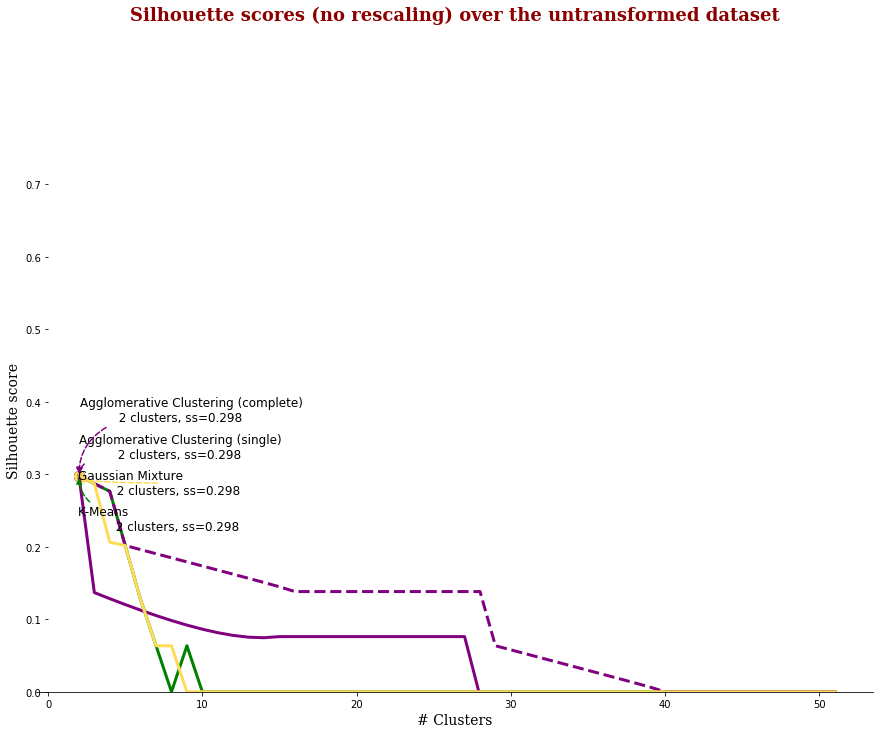

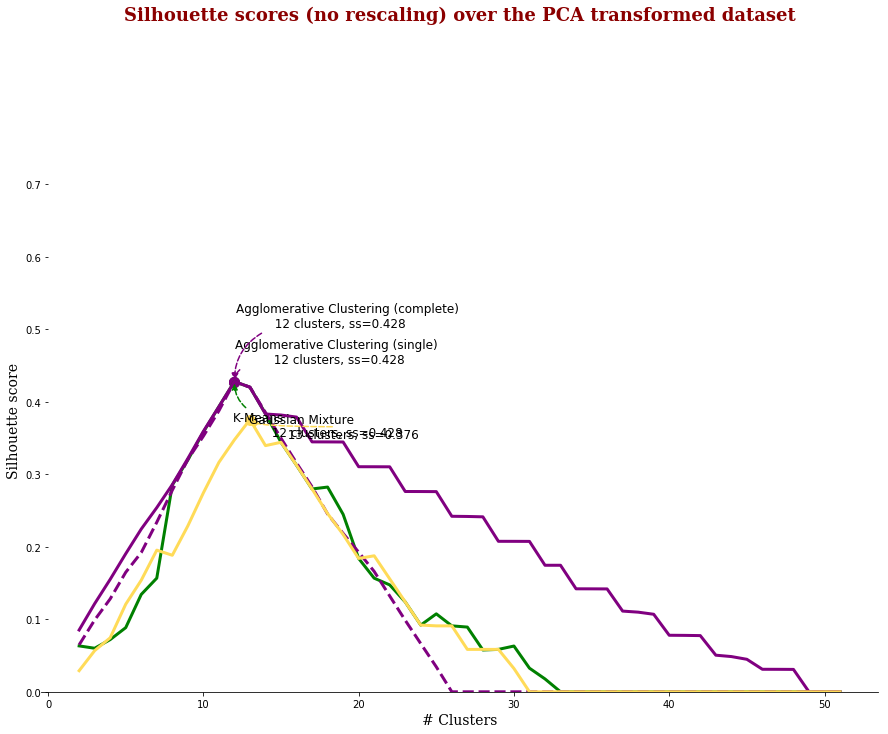

In [9]:
dictAlgorithmsRegular = {}
dictAlgorithmsPCA = {}

if 'Un-Transformed Data' in dictAlgorithms.keys():
    for algorithm in dictAlgorithms['Un-Transformed Data'].keys():
        algInfo = dictAlgorithms['Un-Transformed Data'][algorithm]
        plotargs = algInfo['plotprops']
        dictAlgorithmsRegular[algorithm] = dict(dataframe=algInfo['clusterResults'],**plotargs )
    
if 'PCA Transformed Data' in dictAlgorithms.keys():
    for algorithm in dictAlgorithms['PCA Transformed Data'].keys():
        algInfo = dictAlgorithms['PCA Transformed Data'][algorithm]
        plotargs = algInfo['plotprops']
        dictAlgorithmsPCA[algorithm] = dict(dataframe=algInfo['clusterResults'],**plotargs )
        
PlotClusteringResults (dictAlgorithmsRegular, 'Silhouette scores ' + ('(rescaled with ' + rescaleMode + ')' if rescaleMode != 'None' else '(no rescaling)') + ' over the untransformed dataset')
PlotClusteringResults (dictAlgorithmsPCA    , 'Silhouette scores ' + ('(rescaled with ' + rescaleMode + ')' if rescaleMode != 'None' else '(no rescaling)') + ' over the PCA transformed dataset')


# Look at the base data clustered to see how it performed

In [10]:
# data = 'PCA Transformed Data', 'Un-Transformed Data'
# algorithm = 'K-Means', 'Agglomerative Clustering', 'Agg. Clustering with linkages', 'Gaussian Mixture'


dataset = 'PCA Transformed Data'; algorithm = 'Agglomerative Clustering (single)'

clusterResults = dictAlgorithms[dataset][algorithm]['clusterResults']
clusteredData = pd.merge(dictAlgorithms[dataset][algorithm]['clusteredData'], pd.DataFrame(X_pca), left_index=True, right_index=True)

bestCluster = clusterResults.loc[clusterResults.index>=minClusters, ]['Silhouette Score'].idxmax(); bestClusterColumn = 'cluster_id_{:02d}'.format(bestCluster)

di = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7':7, '8':8, '9': 9, 'A': 10, 'J': 11, 'Q': 12, 'K':13, 'None':0}
clusteredData.replace({'Face Value': di}, inplace=True)
clusteredData = clusteredData.astype({'Face Value': int})
clusteredData.sort_values(['Face Value'], inplace=True)

print('For {1:} algorithm\nover {0:}\n\t best cluster group = {2:2d}'.format(dataset, algorithm, bestCluster))


cols = ['Suit', 'Color', 'Face Value', bestClusterColumn]
clusteredData.loc[:, cols].groupby([bestClusterColumn, 'Color', 'Suit']).count().reset_index().\
                pivot_table(index=bestClusterColumn, columns=['Color', 'Suit'], values='Face Value').fillna('')



For Agglomerative Clustering (single) algorithm
over PCA Transformed Data
	 best cluster group = 12


Color         Black             Red       
Suit          Clubs Spades Diamonds Hearts
cluster_id_12                             
0                 2      2        2      2
1                 1      1        1      1
2                 1      1        1      1
3                 1      1        1      1
4                 1      1        1      1
5                 1      1        1      1
6                 1      1        1      1
7                 1      1        1      1
8                 1      1        1      1
9                 1      1        1      1
10                1      1        1      1
11                1      1        1      1

In [ ]:
fig, currAX = plt.subplots(figsize=(10, 10))

currAX.spines['top'].set_visible(False)
currAX.spines['bottom'].set_visible(False)
currAX.spines['right'].set_visible(False)
currAX.spines['left'].set_visible(False)
#currAX.xaxis.set_visible(False)
#currAX.yaxis.set_visible(False)

plt.yticks(np.arange(0, bestCluster))
plt.xticks(np.arange(1,13))


#sns.violinplot(x=bestClusterColumn, y='Face Value', data=clusteredData, inner=None, color=".9")
sp = sns.stripplot(data=clusteredData, x=bestClusterColumn, y='Face Value', hue='Suit', size=10, ax=currAX, jitter=0.750, palette="Set2", marker="D")


plt.show();

# Present as 3D plot                                                                                    

In [ ]:
cols = ['Suit', 'Color', 'Face Value', bestClusterColumn]
clusteredData.loc[:, cols]

plottingData = dfPlayingCards.copy()

SuitDict  = {suit:i for i, suit in enumerate(dfPlayingCards['Suit'].unique())}
ColorDict = {color:i for i, color in enumerate(dfPlayingCards['Color'].unique())}
FaceValueDict = {fv:i for i, fv in enumerate(dfPlayingCards['Face Value'].unique())}


plottingData.replace({'Suit': SuitDict}, inplace=True)
plottingData.replace({'Color': ColorDict}, inplace=True)
plottingData.replace({'Face Value': FaceValueDict}, inplace=True)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x = plottingData['Suit']
y = plottingData['Color']
z = plottingData['Face Value']
colors = clusteredData[bestClusterColumn]

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_xticklabels(list(SuitDict.keys()))
ax.set_yticklabels(list(ColorDict.keys()))
ax.set_zticklabels(list(FaceValueDict.keys()))

ax.scatter(x, y, z, c=colors, cmap='Dark2', s=300, depthshade=True);

ax.view_init(elev=50., azim=290)

ax.grid(False)
plt.box(False)


plt.show();

# Look at different seed values for K-Means

In [ ]:
dictAlgorithms = \
{
    'PCA Transformed Data':{}
}

clusterRange = (12, 16)

for rs in np.arange(0, 43, 1):
    TestName = 'K-Means_{:02d}'.format(rs)
    d = dict(data=X_pca, algorithm='KMeans', loopRange=clusterRange,
             args=dict(random_state=rs, verbose=False, max_iter=1000, init='random'), 
             plotprops=dict(linestyle='-', color='g', offsetMult=-15)
            )
    dictAlgorithms['PCA Transformed Data'][TestName] = d
    

for datasetName in dictAlgorithms.keys():
    algGrouping = dictAlgorithms[datasetName]
    
    for algorithm in algGrouping:
        algData = algGrouping[algorithm]
        algName = algData['algorithm']
        
        print('Clustering with {:25} '.format(algorithm), end='')        
        dfClusterResults,  dfClusteredData = detectClusters(algData['data'], dfPlayingCards, algorithm=algName, loopRange=algData['loopRange'], **algData['args'])
        algData['clusterResults'] = dfClusterResults; algData['clusteredData'] = dfClusteredData
                
        clusterCount = dfClusterResults['Silhouette Score'].idxmax()
        ss = dfClusterResults.loc[clusterCount]['Silhouette Score']
        print('Best #clusters = {:2d}, Silhouette Score = {:.3f} '.format(clusterCount, ss))
    
    
dictAlgorithmsPCA = {}

if 'PCA Transformed Data' in dictAlgorithms.keys():
    for algorithm in dictAlgorithms['PCA Transformed Data'].keys():
        algInfo = dictAlgorithms['PCA Transformed Data'][algorithm]
        plotargs = algInfo['plotprops']
        dictAlgorithmsPCA[algorithm] = dict(dataframe=algInfo['clusterResults'],**plotargs )
        
PlotClusteringResults (dictAlgorithmsPCA, '') #'Silhouette scores ' + ('(rescaled with ' + rescaleMode + ')' if rescaleMode != 'None' else '(no rescaling)') + ' over the PCA transformed dataset')   

In [ ]:
import matplotlib.cm as cm

dfClusterResults = dictAlgorithms['PCA Transformed Data']['K-Means']['clusterResults']

n_clusters = 13

sample_silhouette_values = dfClusterResults.loc[n_clusters, ['Silhouette Samples']][0]
cluster_labels = dfClusterResults.loc[n_clusters, ['Clusters']][0]

fig, currAX = plt.subplots(figsize=(10,10))

currAX.spines['top'].set_visible(False)
currAX.spines['right'].set_visible(False)
currAX.spines['left'].set_visible(False)
currAX.spines['bottom'].set_visible(True)



y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.Dark2_r(float(i) / n_clusters)
    currAX.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    max_ss = np.max(ith_cluster_silhouette_values)

    # Label the silhouette plots with their cluster numbers at the middle
    currAX.text(max_ss+0.025, y_lower + 0.5 * size_cluster_i, 'cluster {}\n{} members, ss={:.3f}'.format(i, size_cluster_i, max_ss))

    # Compute the new y_lower for next plot
    y_lower = y_upper #+10  # 10 for the 0 samples
        

plt.show();

#cm.Dark2_r

In [ ]:
dictAlgorithms['PCA Transformed Data']['K-Means']['clusteredData'].set_index(['Suit', 'Color', 'Face Value']).loc[:, ['cluster_id_{:02d}'.format(n_clusters)]]

In [ ]:
fig, currAX = plt.subplots(figsize=(15, 6))

currAX.spines['top'].set_visible(False)
currAX.spines['bottom'].set_visible(False)
currAX.spines['left'].set_visible(False)
currAX.spines['right'].set_visible(False)
currAX.xaxis.set_visible(False)
currAX.yaxis.set_visible(False)

dfTrain.boxplot(column='Suit_Clubs', ax=currAX)

plt.show();

## Analyze silhoutte samples to see what is happening

In [ ]:
# data = 'PCA Transformed Data', 'Un-Transformed Data'
# algorithm = 'K-Means', 'Agglomerative Clustering', 'Agg. Clustering with linkages', 'Gaussian Mixture'


import matplotlib.cm as cm
dataset = 'PCA Transformed Data'; algorithm = 'K-Means'

clusterResults = dictAlgorithms[dataset][algorithm]['clusterResults']
clusteredData = pd.merge(dictAlgorithms[dataset][algorithm]['clusteredData'], pd.DataFrame(X_pca), left_index=True, right_index=True)

bestCluster = clusterResults.loc[clusterResults.index>=minClusters, ]['Silhouette Score'].idxmax(); bestClusterColumn = 'cluster_id_{:02d}'.format(bestCluster)

sample_silhouette_values  = clusterResults.loc[bestCluster, ['Silhouette Samples']].values[0]
cluster_labels = clusterResults.loc[bestCluster, ['Clusters']].values[0]

y_lower = 10
#fig, currAX = plt.subplots()
#currAX.set_xlim([-0.1, 1])
#currAX.set_ylim([0, len(sample_silhouette_values) + (n_clusters + 1) * 10])


    
#for i in range(bestCluster):    
#        ith_cluster_silhouette_values = \
#            sample_silhouette_values[cluster_labels == i]

#        ith_cluster_silhouette_values.sort()
        
#        size_cluster_i = ith_cluster_silhouette_values.shape[0]
#        y_upper = y_lower + size_cluster_i

#        color = cm.nipy_spectral(float(i) / bestCluster)
#        currAX.fill_betweenx(np.arange(y_lower, y_upper),
#                          0, ith_cluster_silhouette_values,
#                          facecolor=color, edgecolor=color, alpha=0.7)
#        currAX.text(-0.05, y_lower , str(i))
#        y_lower = y_upper + 10
#currAX.set_yticks([])  # Clear the yaxis labels / ticks
#plt.show();

for i in range(bestCluster):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    print('{:2d}: {}'.format(i, ith_cluster_silhouette_values))